## **Week 4: From MLPs to Convolutional Neural Networks**
### José Manuel López, Alex Martín, Marcos V. Conde

#### <ins>Understanding Layer Manipulation</ins>
1. Check existing architectures
2. Set a new model from an existing architecture
3. Apply model to a small dataset

#### <ins>Deal with dataset loading</ins>
4. Introduce and evaluate Data Augmentation Impact

#### <ins>Hyperparametrs optimization</ins>
4. Introduce and evaluate the usage of dropout, batch normalization, ...
5. Apply random search on model hyperparametes

In [1]:
from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib 
import tensorflow as tf
import warnings
import os

Tensorflow allocates all VRAM without this.
Additionally we want to enable mixed precision aka use TensorCores if our GPU is capable to speedup the computation.

In [2]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus[0])
print(tf.__version__)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.6.0


### Loading Datasets

We are going to define variables related to dataset and load data into generators

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
IMG_SIZE    = 224
BATCH_SIZE  = 64
RANDOM_SEED = 42
CLASSES     = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']
NCLASSES    = len(CLASSES)


def get_dataset(path):
    print("Loading: {}".format(path))
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

    test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
    

    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)
    print("Data Shape: {}".format(example_data.shape))
    print("---"*30)

    return train_loader, test_loader

In [5]:

DATA_DIR = "./MIT_small_train_{}"

# Dataset 1
train_loader_1, test_loader_1 = get_dataset(DATA_DIR.format(1))
# Dataset 2
train_loader_2, test_loader_2 = get_dataset(DATA_DIR.format(2))
# Dataset 3
train_loader_3, test_loader_3 = get_dataset(DATA_DIR.format(3))
# Dataset 4
train_loader_4, test_loader_4 = get_dataset(DATA_DIR.format(4))


Loading: ./MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_2
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_3
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_4
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------


## Check existing architectures: ResNet50
We are going to try ResNet50 pretrained on ImageNet and evaluate the performance of the model.

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

N: 27
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________________

Predicted: [('n03196217', 'digital_clock', 0.05240214), ('n03729826', 'matchstick', 0.041983563), ('n06359193', 'web_site', 0.041426532)]
Real: inside_city


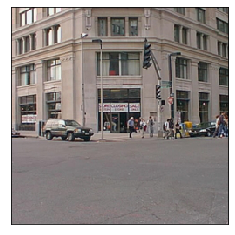

In [17]:
examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)
n = np.random.randint(low = 0, high = len(example_data)+1, size=1)[0]

print("N: {}".format(n))

x = preprocess_input(example_data)

model = ResNet50(weights='imagenet')
print (model.summary())
preds = model.predict(x)

examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)

print('Predicted:', decode_predictions(preds, top=3)[n])
print('Real:', CLASSES[np.argmax(example_targets[n])])

plt.imshow(example_data[n], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

# ResNet50 Finetuning

## Set a new model from an existing architecture

Now we are we are going to use ResNet50's skeleton and use those features to build our classifier. We will add the FC layers and perform the classification.

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [15]:
def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

In [26]:
def buil_custom_resnet50(log=True, lr=1e-3, loss='categorical_crossentropy'):
    
    # ResNet Base Model
    base_model = ResNet50(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet', include_top=False)
    
    x = base_model.output
    
    # We Flatten with GlobalAveragePooling2D()
    x = GlobalAveragePooling2D()(x) # final feature vector

    # Perform classification
    predictions = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # We don't want to modify imagenet weights
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    
    if log:
        print (model.summary())

    return model

In [22]:
DATASETS = [
    (train_loader_1, test_loader_1),
    (train_loader_2, test_loader_2),
    (train_loader_3, test_loader_3),
    (train_loader_4, test_loader_4),
]

In [27]:
# Training on different datasets

for idx, dataset in enumerate(DATASETS):
    
    train_loader = dataset[0]
    test_loader  = dataset[1]
    
    idx +=1
    print ('Training on Dataset', idx, train_loader.samples, test_loader.samples )
    if idx == 1: print_summary=True
    else: print_summary=False
        
    ### LOGS AND TRACKING

    checkpoint = tf.keras.callbacks.ModelCheckpoint  (f'model_{idx}.h5', save_best_only=True, monitor='val_acc', mode='max', verbose=0)
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=10, factor=0.5, min_lr=1e-6, mode='max', verbose=1)
    earlystop  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

        
    model   = buil_custom_resnet50(log=print_summary)
    history = model.fit(train_loader ,steps_per_epoch=train_loader.samples // BATCH_SIZE, epochs=5, validation_data=test_loader, validation_steps=test_loader.samples // BATCH_SIZE)
    
    break
    

Training on Dataset 1 400 2288
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________

Epoch 1/5
6/6 [==============================] - 13s 2s/step - loss: 2.3130 - accuracy: 0.1101 - val_loss: 2.1074 - val_accuracy: 0.1107
Epoch 2/5
6/6 [==============================] - 9s 2s/step - loss: 2.1214 - accuracy: 0.0964 - val_loss: 2.1388 - val_accuracy: 0.1201
Epoch 3/5
6/6 [==============================] - 14s 3s/step - loss: 2.1214 - accuracy: 0.1190 - val_loss: 2.0856 - val_accuracy: 0.1134
Epoch 4/5
6/6 [==============================] - 11s 2s/step - loss: 2.0627 - accuracy: 0.1607 - val_loss: 2.0275 - val_accuracy: 0.2022
Epoch 5/5
6/6 [==============================] - 22s 4s/step - loss: 2.0313 - accuracy: 0.1905 - val_loss: 2.0189 - val_accuracy: 0.2652


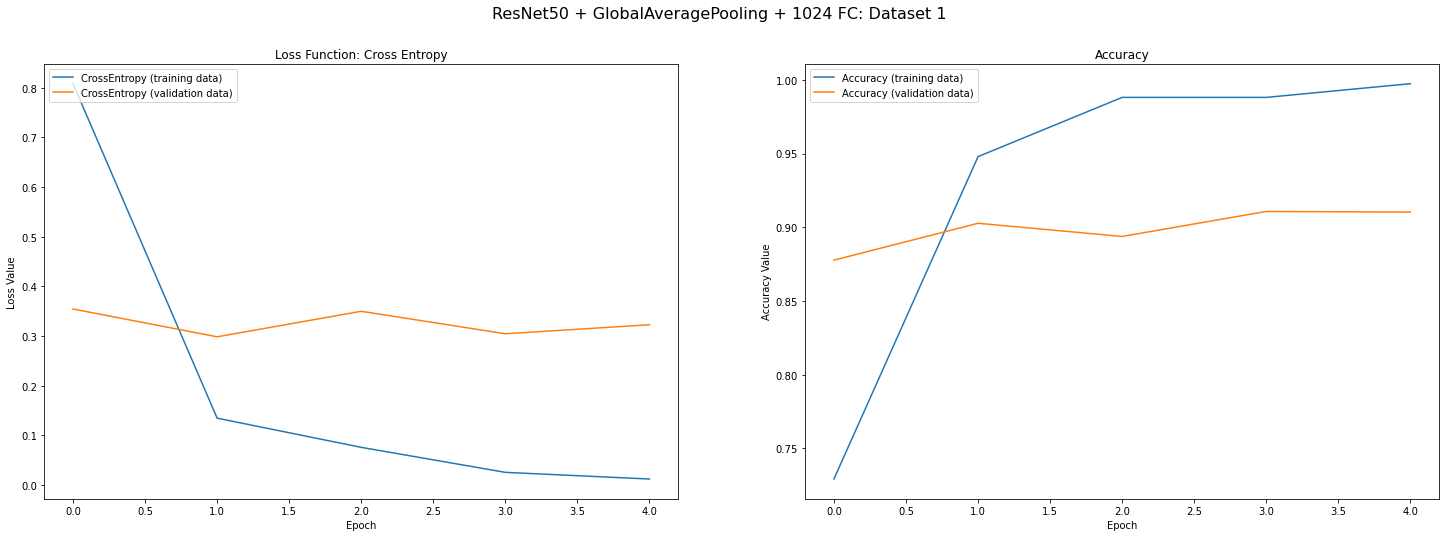

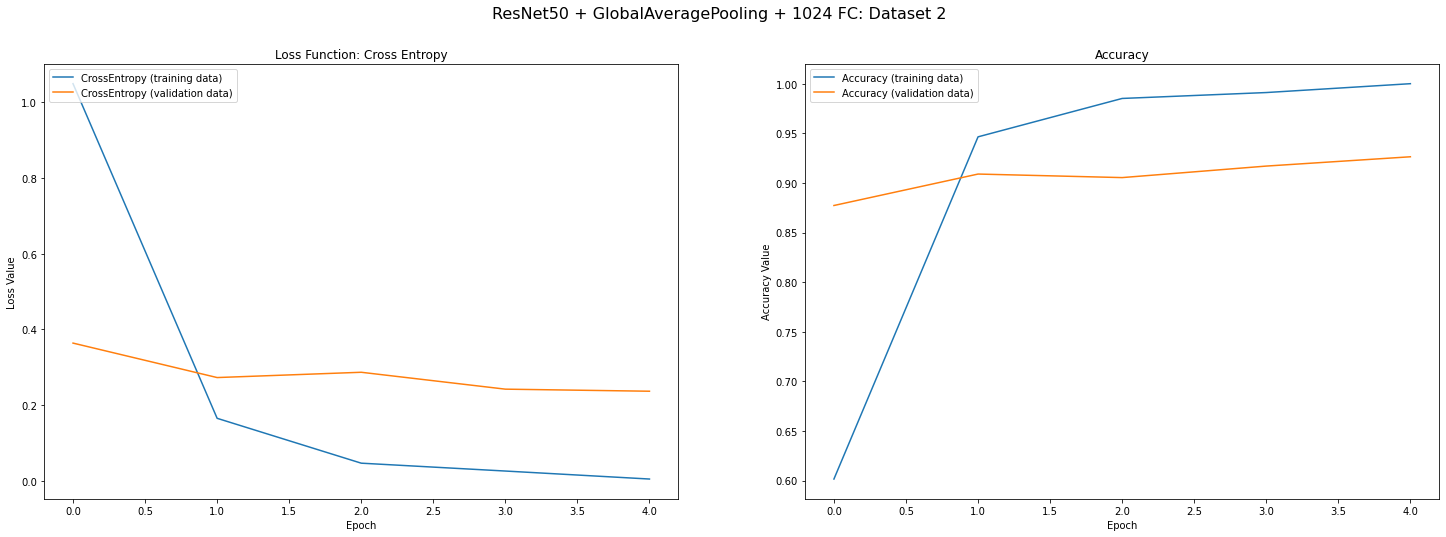

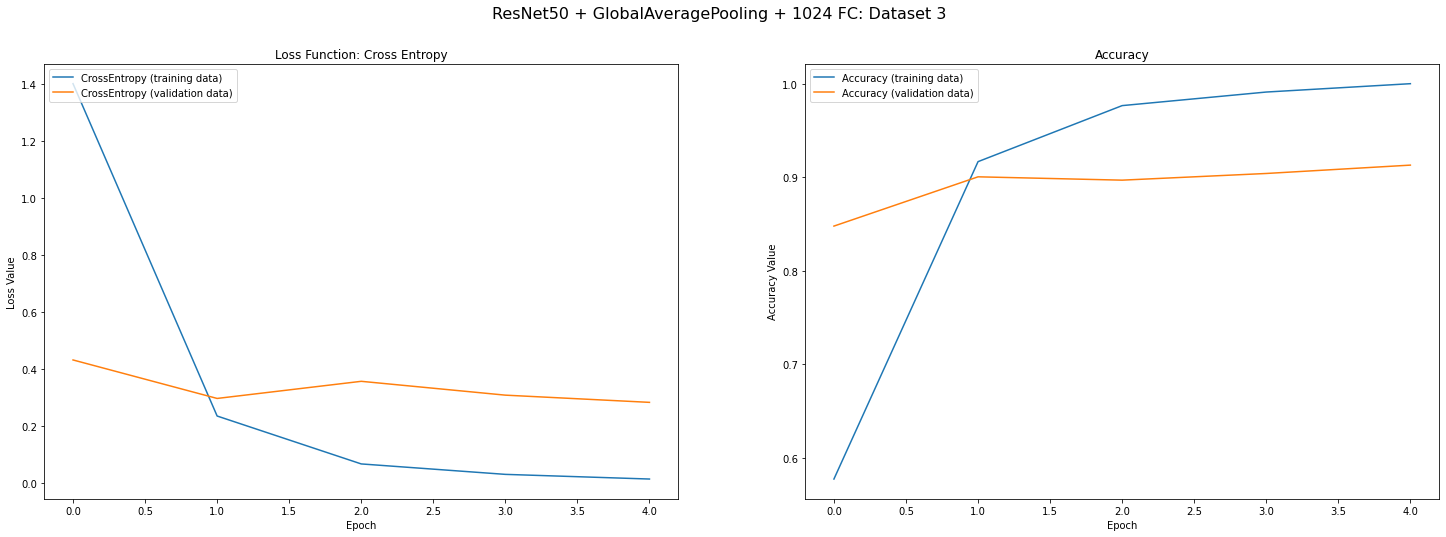

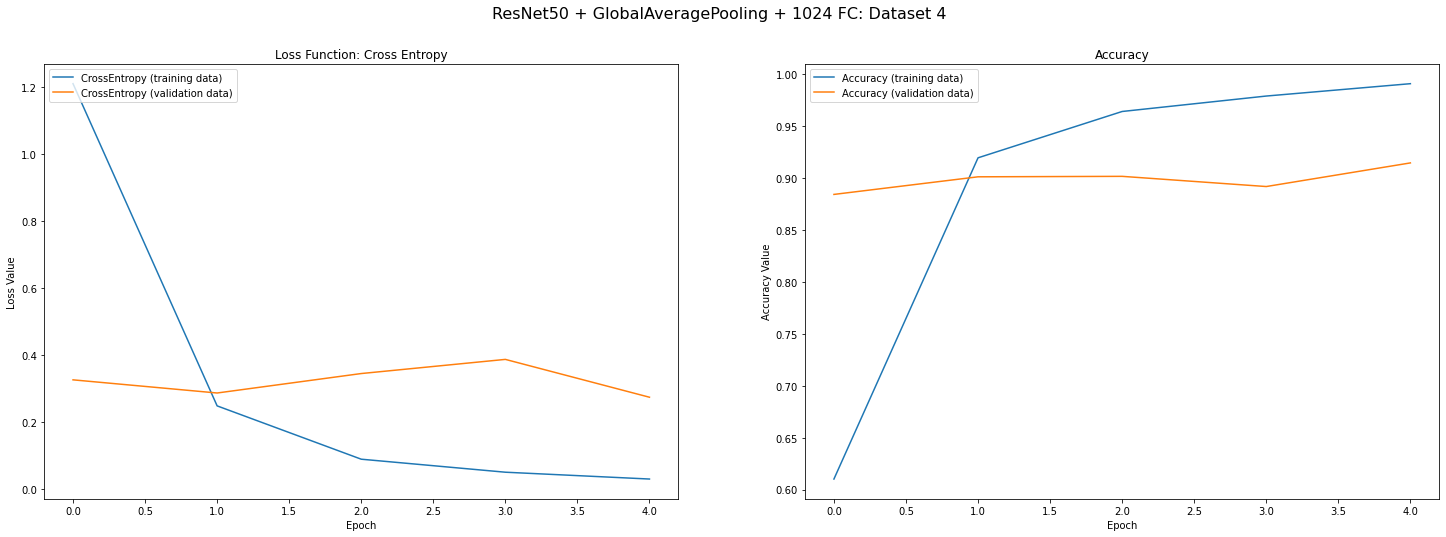

In [21]:
plot_loss_accuracy(history_1, 'ResNet50 + GAP + Dense: Dataset 1')
plot_loss_accuracy(history_2,  'ResNet50 + GAP + Dense: Dataset 2')
plot_loss_accuracy(history_3,  'ResNet50 + GAP + Dense: Dataset 3')
plot_loss_accuracy(history_4,  'ResNet50 + GAP + Dense: Dataset 4')

We observe how ResNet50 + GlobalAveragePooling + 1024 FC outperforms our best MLP model that was around 60% accuracy by a big margin (100% train and 90-93% for test). CNNs show their power when it comes to images.